<h3> Primeiramente vamos importar as bibliotecas relevantes para esse exercício</h3>

In [1]:
import numpy as np
import pickle
import gzip
# import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
# from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

2024-05-22 21:12:37.630482: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 21:12:37.702368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 21:12:38.824929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h3>Funções para preparar o dataset e auxiliar na visualização</h3>

In [2]:
def vector(y):
    vector = np.zeros((10))
    vector[y] = 1
    return vector
        
def vectorize(data):
    results = np.array([vector(y) for y in data])
    return results


In [3]:
def view(data, index):
    values = data[0][index]
    result = data[1][index]
    z = np.reshape(values,(28,28))
    plt.imshow(z)
    plt.gray()
    plt.show()
    print(f'O rótulo para esse dado é ==> {result}')

def plot(data):
    plt.plot(data)

def viewFilter(model):
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue
        
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape, filters.shape[3])
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)

        
        n_filters, ix = filters.shape[3], 1
        for i in range(n_filters):
            f = filters[:, :, :, i]
            ax = pyplot.subplot(n_filters, 6, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(f[:, :, 0], cmap='gray')
            ix += 1
        
        pyplot.show()

<h3>Lê os dados</h3>

In [4]:
file = gzip.open('mnist.pkl.gz', 'rb')
training, validation, test = pickle.load(file, encoding='latin1')
file.close()

<h4>Precisamos fazer um reshape para os dados de treino em forma de uma matriz 28x28x1, senão não dá para fazer convolução. O mesmo para os outputs</h4>

In [5]:
x, y = training[0].reshape(-1,28,28,1), vectorize(training[1])
vx, vy = validation[0].reshape(-1,28,28,1), vectorize(validation[1])
tx, ty = test[0].reshape(-1,28,28,1), vectorize(test[1])

In [6]:
print("x shape: ",x.shape)
print("y shape: ",y.shape)

x shape:  (50000, 28, 28, 1)
y shape:  (50000, 10)


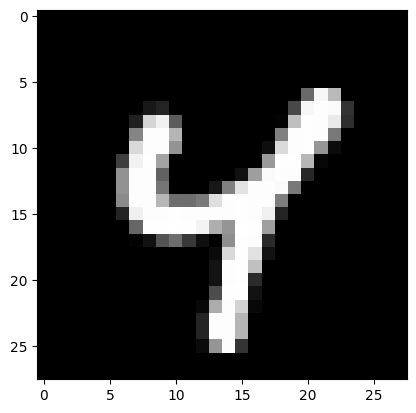

O rótulo para esse dado é ==> 4


In [7]:
index = 1008
view(training,index)

<h3>Criando o modelo</h3>

In [8]:
nn1 = Sequential()
nn1.add(Input(shape=(28,28,1)))
nn1.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))
# nn1.add(Dropout(0.25))

nn1.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# nn1.add(Dropout(0.25))

# Aqui vai uma camada totalmente conectada
nn1.add(Flatten())
nn1.add(Dense(30, activation = "relu"))
# nn1.add(Dropout(0.5))
nn1.add(Dense(10, activation = "softmax"))

# adicionando o otimizador
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

nn1.compile(optimizer = optimizer , loss = "MSE", metrics=["accuracy"])

<h3>Copiando para uma outra rede, só para diversivicar</h3>

In [9]:
nn2 = Sequential()
nn2.add(Input(shape=(28,28,1)))
nn2.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu'))
nn2.add(MaxPool2D(pool_size=(2,2)))
nn2.add(Dropout(0.25))

nn2.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
nn2.add(Dropout(0.25))

# Aqui vai uma camada totalmente conectada
nn2.add(Flatten())
nn2.add(Dense(30, activation = "relu"))
nn2.add(Dropout(0.5))
nn2.add(Dense(10, activation = "softmax"))

# adicionando o otimizador
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

nn2.compile(optimizer = optimizer , loss = "MSE", metrics=["accuracy"])

<h3>Vamos usar também Data Augmentation</h3>

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x)


<h3>Treinando a rede</h3>

In [11]:
epochs = 30 # for better result increase the epochs
batch_size = 100

In [12]:
treino1 = nn1.fit(x,y, epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6902 - loss: 0.0398 - val_accuracy: 0.9497 - val_loss: 0.0079
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9533 - loss: 0.0073 - val_accuracy: 0.9690 - val_loss: 0.0049
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9691 - loss: 0.0049 - val_accuracy: 0.9739 - val_loss: 0.0041
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9747 - loss: 0.0039 - val_accuracy: 0.9774 - val_loss: 0.0035
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9789 - loss: 0.0033 - val_accuracy: 0.9800 - val_loss: 0.0030
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9815 - loss: 0.0029 - val_accuracy: 0.9790 - val_loss: 0.0032
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9829 - loss: 0.0028 - val_accuracy: 0.9807 - val_loss: 0.0030
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9858 - loss: 0.0023 - val_accuracy: 0.

In [13]:
treino2 = nn2.fit(datagen.flow(x,y), epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/30
  12/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1041 - loss: 0.0902

/home/suaide/jupyterhub/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.4531 - loss: 0.0658 - val_accuracy: 0.9519 - val_loss: 0.0082
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7629 - loss: 0.0334 - val_accuracy: 0.9593 - val_loss: 0.0064
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7950 - loss: 0.0292 - val_accuracy: 0.9627 - val_loss: 0.0057
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8172 - loss: 0.0263 - val_accuracy: 0.9639 - val_loss: 0.0055
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8284 - loss: 0.0246 - val_accuracy: 0.9633 - val_loss: 0.0055
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8377 - loss: 0.0236 - val_accuracy: 0.9656 - val_loss: 0.0051
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8420 - loss: 0.0229 - val_accuracy: 0.9681 - val_loss: 0.0048
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8496 - loss: 0.02

<h3>Vê a performance das duas redes</h3>

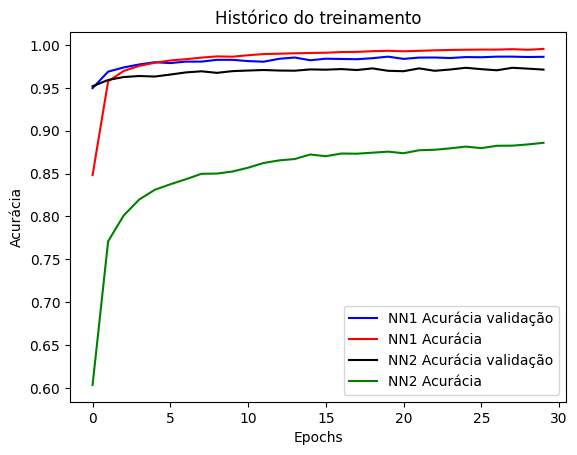

In [14]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(treino1.history['val_accuracy'], color='b', label="NN1 Acurácia validação")
plt.plot(treino1.history['accuracy'], color='r', label="NN1 Acurácia")
plt.plot(treino2.history['val_accuracy'], color='k', label="NN2 Acurácia validação")
plt.plot(treino2.history['accuracy'], color='g', label="NN2 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

<h3>Resumo das duas redes</h3>

In [15]:
nn1.summary()
nn2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 12,892 (50.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,786 (100.73 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 12,892 (50.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,786 (100.73 KB)

<h3>Visualiza os kernels usados como filtros nas camadas de convolução</h3>

conv2d (5, 5, 1, 8) 8


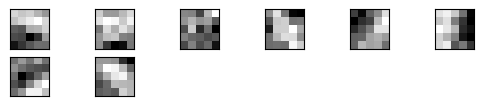

conv2d_1 (3, 3, 8, 8) 8


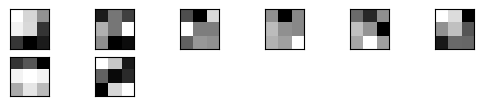

In [16]:
viewFilter(nn1)

conv2d_2 (5, 5, 1, 8) 8


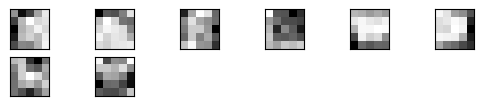

conv2d_3 (3, 3, 8, 8) 8


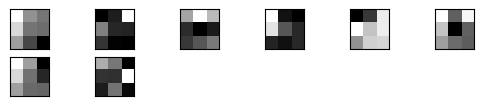

In [17]:
viewFilter(nn2)


<h3>Faz alguma predição nos dados de validação</h3>

In [18]:
pred1 = nn1.predict(vx)
pred2 = nn2.predict(vx)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


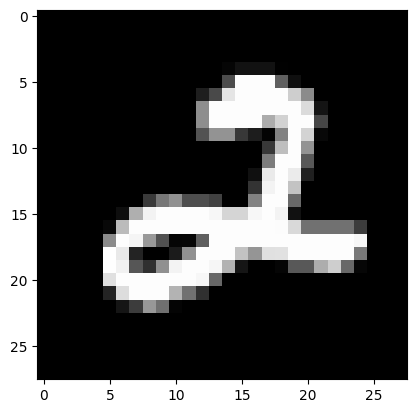

O rótulo para esse dado é ==> 2


In [19]:
index = 8323
view(validation, index)

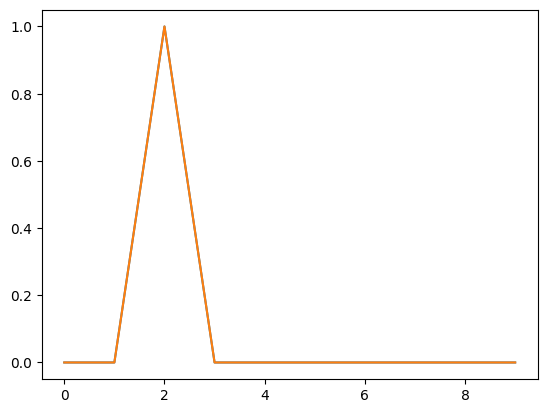

In [20]:
plot(pred1[index])
plot(pred2[index])